In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle
import seaborn as sns

# Initial-preprocessing

In [4]:
# Load in the dataset 
spotify_data=pd.read_csv('../1_data/raw/dataset.csv', index_col=0) #index_col 0 to drop the extra index column

# Select columns of interest
selected_spotify_data = spotify_data[['danceability', 'energy', 'loudness',
                        'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                        'valence', 'tempo', 'track_genre']]

# Drop any Na's
selected_spotify_data = selected_spotify_data.dropna()

# Change bool-type column to integers
# selected_spotify_data["explicit"]=selected_spotify_data["explicit"].astype(int) #True=1 and False=0

# Analysis of dataset

In [5]:
descriptive_stats = selected_spotify_data.describe()
print(descriptive_stats)

        danceability         energy       loudness    speechiness  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.566800       0.641383      -8.258960       0.084652   
std         0.173542       0.251529       5.029337       0.105732   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.456000       0.472000     -10.013000       0.035900   
50%         0.580000       0.685000      -7.004000       0.048900   
75%         0.695000       0.854000      -5.003000       0.084500   
max         0.985000       1.000000       4.532000       0.965000   

        acousticness  instrumentalness       liveness        valence  \
count  114000.000000     114000.000000  114000.000000  114000.000000   
mean        0.314910          0.156050       0.213553       0.474068   
std         0.332523          0.309555       0.190378       0.259261   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.0169

In [6]:
# Select all columns except the last one (genre)
columns_to_include = selected_spotify_data.iloc[:, :-1]

# Compute correlation matrix
correlation_matrix = columns_to_include.corr()

# Print correlation matrix
print(correlation_matrix)

                  danceability    energy  loudness  speechiness  acousticness  \
danceability          1.000000  0.134325  0.259077     0.108626     -0.171533   
energy                0.134325  1.000000  0.761690     0.142509     -0.733906   
loudness              0.259077  0.761690  1.000000     0.060826     -0.589803   
speechiness           0.108626  0.142509  0.060826     1.000000     -0.002186   
acousticness         -0.171533 -0.733906 -0.589803    -0.002186      1.000000   
instrumentalness     -0.185606 -0.181879 -0.433477    -0.089616      0.104027   
liveness             -0.131617  0.184796  0.076899     0.205219     -0.020700   
valence               0.477341  0.258934  0.279848     0.036635     -0.107070   
tempo                -0.050450  0.247851  0.212446     0.017273     -0.208224   

                  instrumentalness  liveness   valence     tempo  
danceability             -0.185606 -0.131617  0.477341 -0.050450  
energy                   -0.181879  0.184796  0.258934 

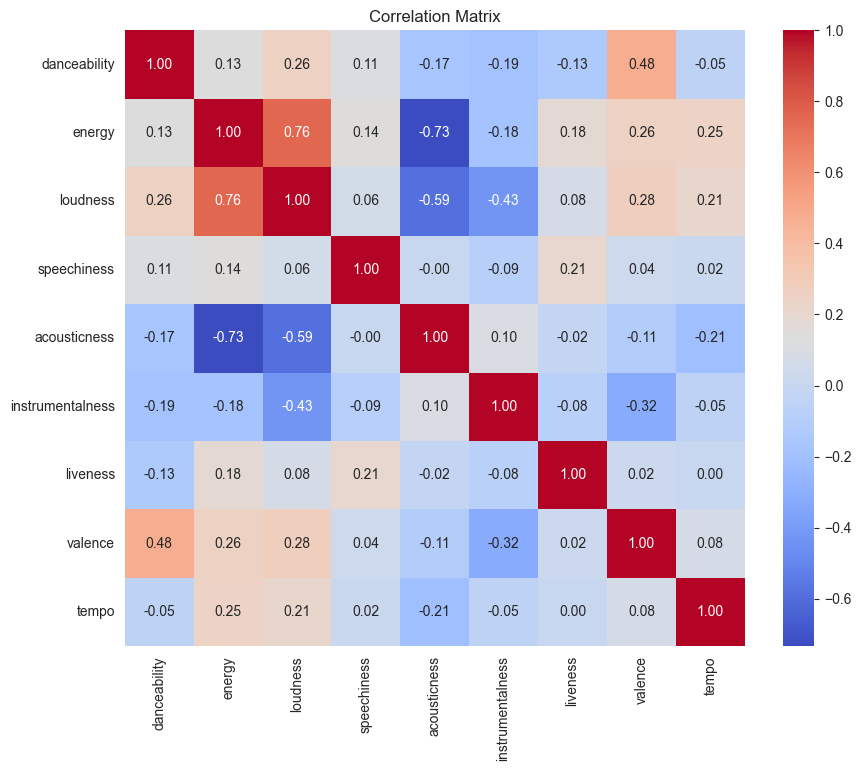

In [7]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Compute the maximum absolute values for 'loudness' and 'tempo' columns
max_abs_loudness = selected_spotify_data['loudness'].abs().max()
max_abs_tempo = selected_spotify_data['tempo'].abs().max()

# Divide the 'loudness' column by its maximum absolute value
selected_spotify_data['loudness'] = selected_spotify_data['loudness'] / max_abs_loudness

# Divide the 'tempo' column by its maximum absolute value
selected_spotify_data['tempo'] = selected_spotify_data['tempo'] / max_abs_tempo

print(max_abs_loudness)
print(max_abs_tempo)

49.531
243.372


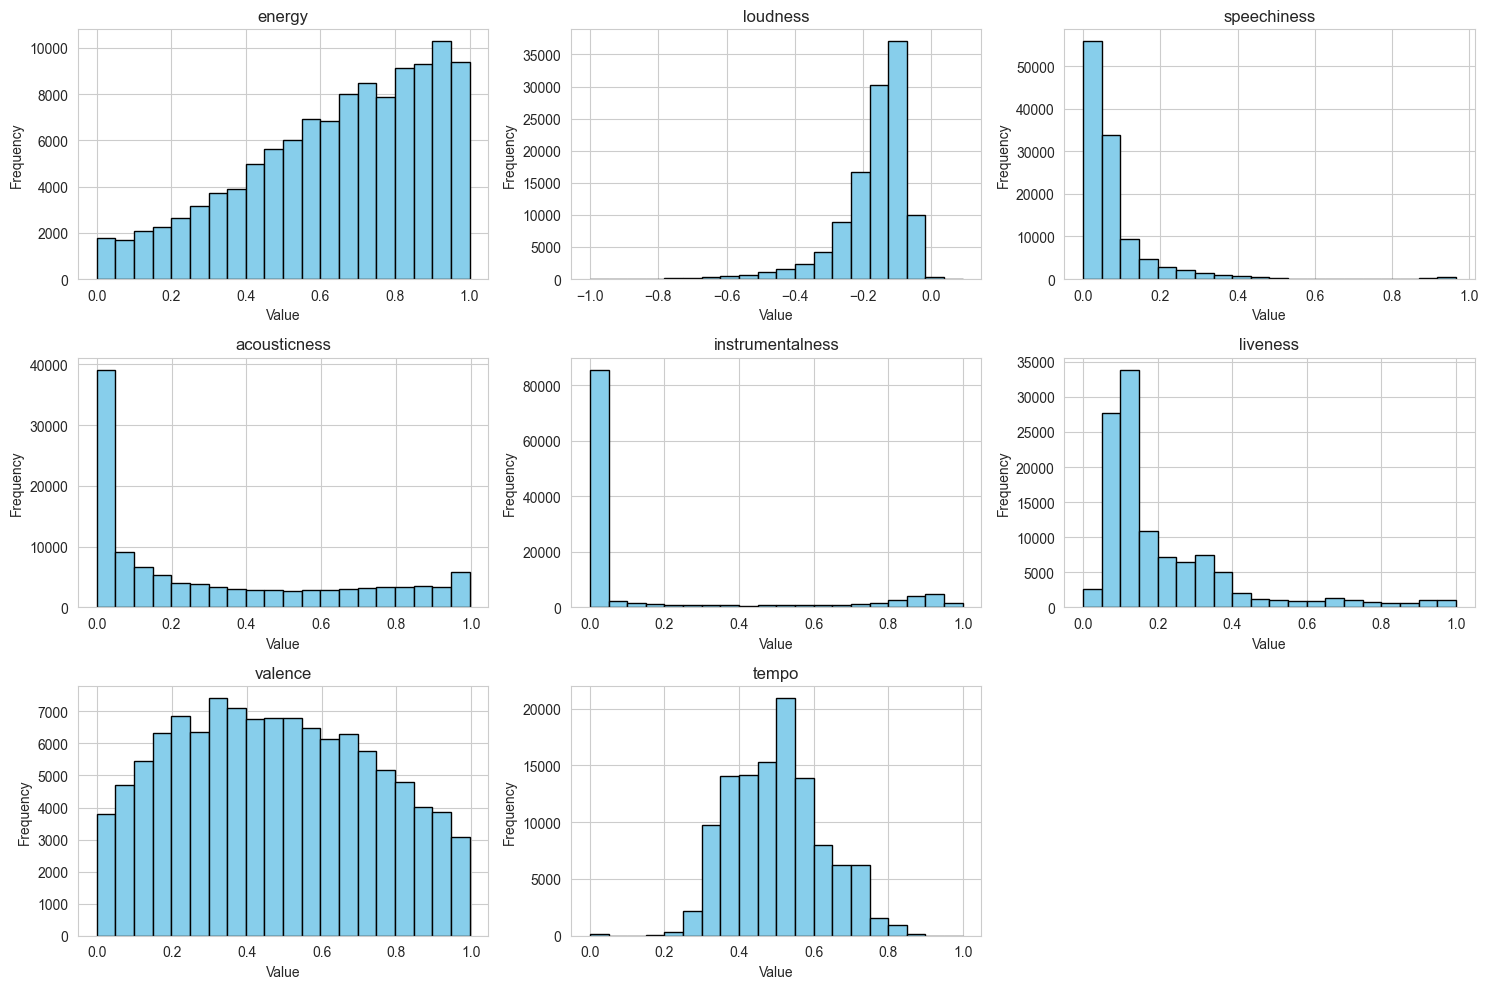

In [9]:
import matplotlib.pyplot as plt
import math

# Select all columns except the last one (genre)
columns_to_include = selected_spotify_data.iloc[:, 1:-1]

# Determine the number of rows and columns for the subplot grid
num_columns = columns_to_include.shape[1]
num_rows = math.ceil(num_columns / 3)

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 10))

# Flatten the axes array to facilitate iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(columns_to_include.columns):
    ax = axes[i]  # Get the current axis
    ax.hist(columns_to_include[column], bins=20, color='skyblue', edgecolor='black', zorder=2)
    ax.set_title(column)  # Set the title of the subplot
    ax.set_xlabel('Value')  # Set the x-axis label
    ax.set_ylabel('Frequency')  # Set the y-axis label
    ax.grid(True, zorder=0)  # Add gridlines

# Hide empty subplots if necessary
for i in range(num_columns, num_rows * 3):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [10]:
selected_spotify_data['track_genre'].unique()


array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [11]:
selected_spotify_data

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
0,0.676,0.4610,-0.136198,0.1430,0.0322,0.000001,0.3580,0.7150,0.361245,acoustic
1,0.420,0.1660,-0.347964,0.0763,0.9240,0.000006,0.1010,0.2670,0.318397,acoustic
2,0.438,0.3590,-0.196523,0.0557,0.2100,0.000000,0.1170,0.1200,0.313643,acoustic
3,0.266,0.0596,-0.373806,0.0363,0.9050,0.000071,0.1320,0.1430,0.746758,acoustic
4,0.618,0.4430,-0.195453,0.0526,0.4690,0.000000,0.0829,0.1670,0.492863,acoustic
...,...,...,...,...,...,...,...,...,...,...
113995,0.172,0.2350,-0.330964,0.0422,0.6400,0.928000,0.0863,0.0339,0.517705,world-music
113996,0.174,0.1170,-0.369829,0.0401,0.9940,0.976000,0.1050,0.0350,0.350242,world-music
113997,0.629,0.3290,-0.219963,0.0420,0.8670,0.000000,0.0839,0.7430,0.543933,world-music
113998,0.587,0.5060,-0.219842,0.0297,0.3810,0.000000,0.2700,0.4130,0.558651,world-music


    'Other': ['afrobeat', 'anime', 'brazil', 'british', 'cantopop', 'children', 'french', 'german', 'indian', 
              'iranian', 'j-dance', 'j-idol', 'malay', 
              'mandopop', 'new-age', 'pagode', 'sertanejo', 'spanish', 'swedish', 
              'tango', 'turkish', 'world-music'

In [21]:
# Genre to category mapping for playlist creation
genre_to_category = {
    # EDM
    'edm': 'Electronic Dance Music', 
    'house': 'Electronic Dance Music', 
    'electro': 'Electronic Dance Music', 
    'trance': 'Electronic Dance Music', 
    'techno': 'Electronic Dance Music', 
    'dubstep': 'Electronic Dance Music', 
    'drum-and-bass': 'Electronic Dance Music', 
    'deep-house': 'Electronic Dance Music', 
    'detroit-techno': 'Electronic Dance Music', 
    'minimal-techno': 'Electronic Dance Music', 
    'progressive-house': 'Electronic Dance Music', 
    'breakbeat': 'Electronic Dance Music',
    
    # Rock
    'alt-rock': 'Rock', 
    'rock': 'Rock', 
    'indie': 'Rock', 
    'indie-pop': 'Rock', 
    'punk': 'Rock', 
    'punk-rock': 'Rock', 
    'hard-rock': 'Rock', 
    'metal': 'Rock', 
    'heavy-metal': 'Rock', 
    'black-metal': 'Rock', 
    'death-metal': 'Rock', 
    'grunge': 'Rock',
    
    # Hip-Hop and R&B
    'hip-hop': 'Hip-Hop and R&B', 
    'r-n-b': 'Hip-Hop and R&B', 
    'trap': 'Hip-Hop and R&B',
    
    # Pop
    'pop': 'Pop', 
    'electro-pop': 'Pop', 
    'synth-pop': 'Pop', 
    'k-pop': 'Pop', 
    'pop-film': 'Pop', 
    'power-pop': 'Pop',
    
    # Latin & Reggae/Dancehall
    'latin': 'Latin & Reggae/Dancehall', 
    'reggaeton': 'Latin & Reggae/Dancehall', 
    'salsa': 'Latin & Reggae/Dancehall', 
    'samba': 'Latin & Reggae/Dancehall', 
    'reggae': 'Latin & Reggae/Dancehall', 
    'dancehall': 'Latin & Reggae/Dancehall',
    
    # Funk and Disco
    'funk': 'Funk and Disco', 
    'disco': 'Funk and Disco', 
    'groove': 'Funk and Disco',
}

# Map each track to a category
selected_spotify_data['music_category'] = selected_spotify_data['track_genre'].apply(lambda x: genre_to_category.get(x, 'Other'))

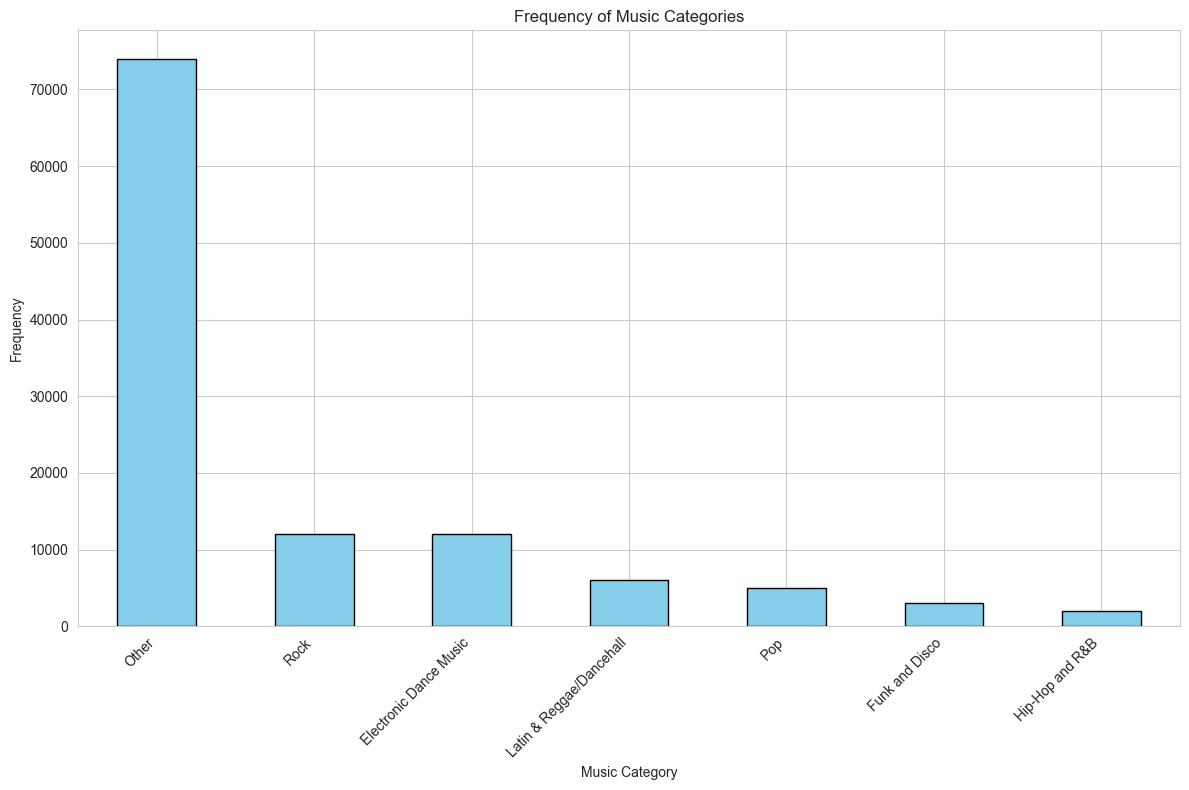

In [30]:
# genre_categories = {
#     'Acoustic': ['acoustic', 'chill', 'folk'],
#     'Electronic': ['ambient', 'breakbeat', 'chicago-house', 'club', 'deep-house', 'detroit-techno', 'disco', 
#                     'drum-and-bass', 'dubstep', 'edm', 'electro', 'electronic', 'hardstyle', 'house', 'idm', 
#                     'minimal-techno', 'progressive-house', 'techno', 'trance', 'trip-hop'],
#     'Hip-Hop/R&B/Soul': ['hip-hop','funk', 'gospel', 'groove', 'r-n-b', 'soul'],
#     'Indie': ['alt-rock', 'alternative', 'emo', 'grunge', 'indie-pop', 'indie'],
#     'Metal': ['black-metal', 'death-metal', 'heavy-metal', 'metal', 'metalcore'],
#     'Pop': ['pop-film', 'pop', 'power-pop', 'k-pop', 'j-pop'],
#     'Reggae/Dancehall & Latin': ['dancehall', 'dub', 'reggae', 'reggaeton', 'ska', 'latin', 'salsa', 'samba', 'latino'],
#     'Rock': ['hard-rock', 'hardcore', 'punk-rock', 'punk', 'rock-n-roll', 'rock', 'rockabilly', 'j-rock'],
#     'World': ['afrobeat', 'anime', 'brazil', 'british', 'cantopop', 'children', 'french', 'german', 'indian', 
#               'iranian', 'j-dance', 'j-idol', 'malay', 
#               'mandopop', 'new-age', 'pagode', 'sertanejo', 'spanish', 'swedish', 
#               'tango', 'turkish', 'world-music'
#               ]
# }
# # Define a default category for unspecified genres
# default_category = 'Other'
# 
# # Reverse mapping to get genre from category
# category_to_genre = {genre: category for category, genres in genre_categories.items() for genre in genres}
# 
# # Map genres to categories
# selected_spotify_data['music_category'] = selected_spotify_data['track_genre'].map(category_to_genre).fillna(default_category)

# Count the frequencies of each category
category_counts = selected_spotify_data['music_category'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Music Categories')
plt.xlabel('Music Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


# Modelling

In [23]:

# Split data into features (X) and target variable (y)
X = selected_spotify_data.drop(columns=['music_category', 'track_genre'])
y = selected_spotify_data['music_category']

# Cast all X columns to floats
X = X.astype(float)

# Encode the categorical target variable y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler(with_mean=True)



# Split data into training, validation, and testing sets
X_test, X_temp, y_test, y_temp = train_test_split(X, y_encoded, test_size=0.9, random_state=100)

X_temp = scaler.fit_transform(X_temp)
X_test = scaler.transform(X_test)

kmeans = KMeans(n_clusters=7, random_state=48) 
X_temp['cluster'] = kmeans.fit_predict(X_temp)


X_val, X_train, y_val, y_train = train_test_split(X_temp, y_temp, test_size=8/9, random_state=100)



# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (91200, 9) (91200,)
Validation set: (11400, 9) (11400,)
Test set: (11400, 9) (11400,)


In [24]:
import numpy as np

# Get unique encoded labels
unique_encodings = np.unique(y_encoded)

# Get the number of unique encodings
num_unique_encodings = len(unique_encodings)

print("Number of unique encodings:", num_unique_encodings)

Number of unique encodings: 7


In [25]:
missing_values = y.isna().sum()
print("Number of missing values in y:", missing_values)

Number of missing values in y: 0


In [26]:


# Get unique encoded labels and their corresponding original labels
unique_encoded_labels = np.unique(y_encoded)
original_labels = label_encoder.inverse_transform(unique_encoded_labels)

# Print unique encoded labels along with their corresponding original labels
print("Unique encoded labels with corresponding original labels:")
for encoded_label, original_label in zip(unique_encoded_labels, original_labels):
    print(f"Encoded label: {encoded_label}, Original label: {original_label}")


Unique encoded labels with corresponding original labels:
Encoded label: 0, Original label: Electronic Dance Music
Encoded label: 1, Original label: Funk and Disco
Encoded label: 2, Original label: Hip-Hop and R&B
Encoded label: 3, Original label: Latin & Reggae/Dancehall
Encoded label: 4, Original label: Other
Encoded label: 5, Original label: Pop
Encoded label: 6, Original label: Rock


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001  # Example learning rate, you can adjust this value as needed

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define the model architecture with dropout and batch normalization
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),  # Batch normalization layer
    layers.Dropout(0.2),          # Dropout layer with dropout rate 0.2 (adjust as needed)
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_unique_encodings, activation='softmax')  # Output layer with softmax activation for classification
])

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # For integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(X_test, y_test, epochs=100, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/100


2024-05-11 21:18:30.715858: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


357/357 [==============================] - 9s 21ms/step - loss: 1.3730 - accuracy: 0.5406 - val_loss: 1.0698 - val_accuracy: 0.6354
Epoch 2/100
357/357 [==============================] - 6s 18ms/step - loss: 1.0861 - accuracy: 0.6458 - val_loss: 1.0516 - val_accuracy: 0.6475
Epoch 3/100
357/357 [==============================] - 6s 17ms/step - loss: 1.0776 - accuracy: 0.6454 - val_loss: 1.0276 - val_accuracy: 0.6641
Epoch 4/100
357/357 [==============================] - 6s 18ms/step - loss: 1.0701 - accuracy: 0.6532 - val_loss: 1.0308 - val_accuracy: 0.6596
Epoch 5/100
357/357 [==============================] - 6s 18ms/step - loss: 1.0563 - accuracy: 0.6555 - val_loss: 1.0275 - val_accuracy: 0.6637
Epoch 6/100
357/357 [==============================] - 6s 18ms/step - loss: 1.0493 - accuracy: 0.6562 - val_loss: 1.0221 - val_accuracy: 0.6642
Epoch 7/100
357/357 [==============================] - 6s 17ms/step - loss: 1.0638 - accuracy: 0.6514 - val_loss: 1.0464 - val_accuracy: 0.6640
Epoc

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

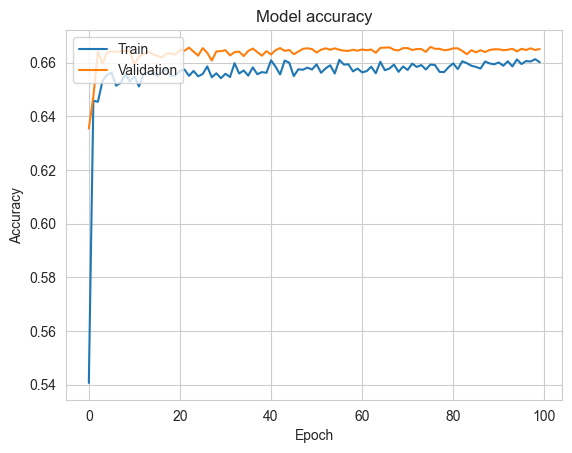

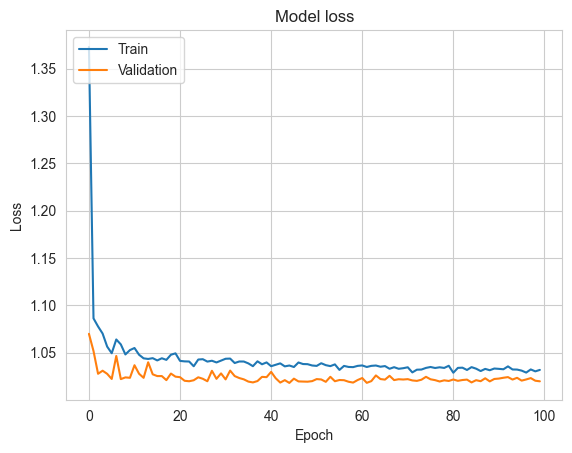

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Classification Report:\n{classification_report(y_val, y_pred, target_names=label_encoder.classes_)}\n")

Random Forest Classification Report:
                          precision    recall  f1-score   support

  Electronic Dance Music       0.64      0.53      0.58      1188
          Funk and Disco       0.20      0.09      0.12       270
         Hip-Hop and R&B       0.21      0.07      0.11       212
Latin & Reggae/Dancehall       0.55      0.43      0.48       600
                   Other       0.76      0.88      0.82      7449
                     Pop       0.64      0.23      0.34       507
                    Rock       0.57      0.43      0.49      1174

                accuracy                           0.71     11400
               macro avg       0.51      0.38      0.42     11400
            weighted avg       0.69      0.71      0.69     11400


/Users/grzegorzlaska/Desktop/PycharmProjects/pythonProject1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grzegorzlaska/Desktop/PycharmProjects/pythonProject1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/grzegorzlaska/Desktop/PycharmProjects/pythonProject1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

SVM Classification Report:
                          precision    recall  f1-score   support

  Electronic Dance Music       0.64      0.27      0.38      1188
          Funk and Disco       0.00      0.00      0.00       270
         Hip-Hop and R&B       0.00      0.00      0.00       212
Latin & Reggae/Dancehall       0.00      0.00      0.00       600
                   Other       0.67      0.98      0.79      7449
                     Pop       0.00      0.00      0.00       507
                    Rock       0.50      0.01      0.02      1174

                accuracy                           0.67     11400
               macro avg       0.26      0.18      0.17     11400
            weighted avg       0.56      0.67      0.56     11400

K-Nearest Neighbors Classification Report:
                          precision    recall  f1-score   support

  Electronic Dance Music       0.50      0.56      0.53      1188
          Funk and Disco       0.22      0.13      0.16       270
  

In [27]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Clean Data
music_data = pd.read_csv('data/dataset.csv')
music_data.dropna(inplace=True)
music_data.drop_duplicates(inplace=True)

X = music_data.drop(columns = ["track_id", "artists", "album_name", "track_name", "track_genre"])
y = music_data["track_genre"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)
print(score)

0.9986491228070176


In [29]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=0),
    'SVM': SVC(random_state=0),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    

0.8811578947368421
0.19550877192982455
0.7432105263157894
0.9986491228070176
